In [1]:
from utils import CustomDataset, TestingDataset, transform
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from resnet_model_mask import  ResidualBlock, ResNet
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
num_gpus = torch.cuda.device_count()
print(num_gpus)

6


In [2]:
model = ResNet(3, ResidualBlock, [3, 4, 6, 3], num_classes=2).to(device)
model = nn.DataParallel(model).to(device)

model.load_state_dict(torch.load('../cnn/models_8/model-109-99.565.pt'))
model = model.eval()

num params encoder  19395


In [3]:
# Create custom dataset instance
test_data_dir = '/mnt/buf0/pma/frbnn/test_ready'
test_dataset = TestingDataset(test_data_dir, transform=transform, bit8=True)
# test_dataset = CustomDataset(test_data_dir, transform=transform)

testloader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=32)
num_classes = 2

In [4]:
dm_ranges = np.linspace(5, 1000, 8)
snr_ranges = np.linspace(10, 100, 8)
freq_ranges = np.linspace(900, 2157.7199, 100)
boxcar_ranges = np.power(10,np.linspace(np.log10(6.4e-5), np.log10(0.032), 8))
print(boxcar_ranges)

[6.40000000e-05 1.55505988e-04 3.77845506e-04 9.18081856e-04
 2.23073791e-03 5.42020474e-03 1.31699108e-02 3.20000000e-02]


In [5]:
from tqdm import tqdm
# eval
model.training
val_loss = 0.0
correct_valid = 0
total = 0
results = {'pred': [], 'true':[], 'freq':[], 'snr':[], 'dm':[], 'boxcar':[]}
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        inputs, labels = images.to(device), labels
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        results['pred'].extend(predicted.cpu().numpy().tolist())
        results['true'].extend(labels[0].cpu().numpy().tolist())
        results['freq'].extend(labels[2].cpu().numpy().tolist())
        results['dm'].extend(labels[1].cpu().numpy().tolist())
        results['snr'].extend(labels[3].cpu().numpy().tolist())
        results['boxcar'].extend(labels[4].cpu().numpy().tolist())
        total += labels[0].size(0)
        correct_valid += (predicted.cpu() == labels[0].cpu()).sum().item()
    
# Calculate training accuracy after each epoch
val_accuracy = correct_valid / total * 100.0
print("===========================")
print('accuracy: ',  val_accuracy)
print("===========================")

accuracy:  99.535


1
freq  1788.128272251309
dm  677.4130796511862
snr  88.42091624342461


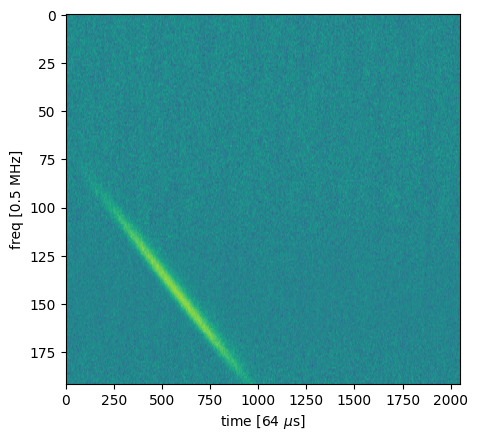

In [6]:
import matplotlib.pyplot as plt
idn = 20
# plt.imshow(np.log10(inputs[idn,0,:,:].cpu().numpy()), aspect = 10)
plt.imshow(inputs[idn,0,:,:].cpu().numpy(), aspect = 10)
plt.xlabel('time [64 $\mu$s]')
plt.ylabel('freq [0.5 MHz]')
print(labels[0].cpu().numpy().tolist()[idn])
print('freq ',labels[2].cpu().numpy().tolist()[idn])
print('dm ',labels[1].cpu().numpy().tolist()[idn])
print('snr ',labels[3].cpu().numpy().tolist()[idn])

In [35]:
recall_matrix = np.zeros((dm_ranges.shape[0]-1,snr_ranges.shape[0]-1))
for i in range(1, dm_ranges.shape[0]):
    for j in range(1, snr_ranges.shape[0]):
        end_dm = dm_ranges[i]
        start_dm = dm_ranges[i-1]

        start_snr = snr_ranges[j-1]
        end_snr = snr_ranges[j]
    
        dm_index = set(np.where( np.logical_and(end_dm > np.array(results['dm']), start_dm<np.array(results['dm'])))[0].tolist())
        snr_index = set(np.where( np.logical_and(end_snr > results['snr'], start_snr< results['snr']))[0].tolist())
        label_index = set(np.where(1 == np.array(results['true']))[0].tolist())

        filtered = (np.array(list(dm_index & snr_index & label_index )),) 
        pred = np.mean(np.array(results['pred'])[filtered])
        recall_matrix[i-1,j-1] = pred * 100

In [1]:
plt.figure(figsize=(10,10))
plt.imshow(recall_matrix, interpolation='nearest', vmin=80, vmax=100, cmap='plasma')

# Add text annotations to each cell
for i in range(recall_matrix.shape[0]):
    for j in range(recall_matrix.shape[1]):
        plt.text(j, i, f'{recall_matrix[i, j]:.1f}', ha='center', va='center', color='black',  fontsize = 15)

cb1 = plt.colorbar( label='Recall %',shrink=0.7, aspect=15,)
cb1.set_label('Recall %', fontsize=25)  # Set label font size

plt.xlabel('SNR ', fontsize = 25)
plt.ylabel('DM ',  fontsize = 25)

xtick_positions = np.arange(0, recall_matrix.shape[1], 1)  # Custom x tick positions
ytick_positions = np.arange(0, recall_matrix.shape[0], 1)  # Custom y tick positions
xtick_labels    =  snr_ranges[:-1]# Custom x tick labels
for i in range(len(xtick_labels)):
    xtick_labels[i] = round(xtick_labels[i], 2)

ytick_labels = dm_ranges[:-1]  # Custom y tick labels
for i in range(len(ytick_labels)):
    ytick_labels[i] = round(ytick_labels[i], 2)


plt.xticks(ticks=xtick_positions, labels=xtick_labels, fontsize = 20)
plt.yticks(ticks=ytick_positions, labels=ytick_labels,  fontsize = 20)
plt.tight_layout()
# plt.title('Retrieval Rate', fontsize = 30)
plt.savefig("8bit_recall_dm_snr.pdf", format='pdf')

NameError: name 'plt' is not defined

In [9]:
dm_ranges = np.linspace(5, 1000, 8)
snr_ranges = np.linspace(10, 100, 8)
freq_ranges = np.linspace(900, 2157.7199, 100)
boxcar_ranges = np.power(10,np.linspace(np.log10(6.4e-5), np.log10(0.032), 5))
print(boxcar_ranges)

[6.40000000e-05 3.02637315e-04 1.43108351e-03 6.76717609e-03
 3.20000000e-02]


In [10]:
from tqdm import tqdm
# eval
model.training
val_loss = 0.0
correct_valid = 0
total = 0
results = {'pred': [], 'true':[], 'freq':[], 'snr':[], 'dm':[], 'boxcar':[]}
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        inputs, labels = images.to(device), labels
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        results['pred'].extend(predicted.cpu().numpy().tolist())
        results['true'].extend(labels[0].cpu().numpy().tolist())
        results['freq'].extend(labels[2].cpu().numpy().tolist())
        results['dm'].extend(labels[1].cpu().numpy().tolist())
        results['snr'].extend(labels[3].cpu().numpy().tolist())
        results['boxcar'].extend(labels[4].cpu().numpy().tolist())
        total += labels[0].size(0)
        correct_valid += (predicted.cpu() == labels[0].cpu()).sum().item()
    
# Calculate training accuracy after each epoch
val_accuracy = correct_valid / total * 100.0
print("===========================")
print('accuracy: ',  val_accuracy)
print("===========================")

accuracy:  99.535


In [11]:
np.array(results['boxcar']).max()

0.032512

In [12]:
recall_matrix = np.zeros((dm_ranges.shape[0]-1, boxcar_ranges.shape[0]-1))
for i in range(1, dm_ranges.shape[0]):
    for j in range(1, boxcar_ranges.shape[0]):
        end_dm = dm_ranges[i]
        start_dm = dm_ranges[i-1]

        start_boxcar = boxcar_ranges[j-1]
        end_boxcar= boxcar_ranges[j]
    
        dm_index = set(np.where( np.logical_and(end_dm > np.array(results['dm']), start_dm < np.array(results['dm'])))[0].tolist())
        boxcar_index = set(np.where( np.logical_and(end_boxcar > np.array(results['boxcar']), start_boxcar<  np.array(results['boxcar'])))[0].tolist())
        label_index = set(np.where(1 == np.array(results['true']))[0].tolist())
        
        filtered = (np.array(list(dm_index & boxcar_index & label_index )),) 
        pred = np.mean(np.array(results['pred'])[filtered])
        recall_matrix[i-1,j-1] = pred * 100
        print(pred * 100, start_boxcar)

98.31932773109243 6.400000000000005e-05
99.35205183585313 0.0003026373148810165
98.49246231155779 0.0014310835055998665
98.95104895104895 0.006767176086019615
98.63945578231292 6.400000000000005e-05
99.81684981684981 0.0003026373148810165
100.0 0.0014310835055998665
99.66996699669967 0.006767176086019615
100.0 6.400000000000005e-05
100.0 0.0003026373148810165
99.79591836734694 0.0014310835055998665
100.0 0.006767176086019615
100.0 6.400000000000005e-05
100.0 0.0003026373148810165
100.0 0.0014310835055998665
100.0 0.006767176086019615
100.0 6.400000000000005e-05
100.0 0.0003026373148810165
99.82638888888889 0.0014310835055998665
100.0 0.006767176086019615
100.0 6.400000000000005e-05
100.0 0.0003026373148810165
100.0 0.0014310835055998665
100.0 0.006767176086019615
100.0 6.400000000000005e-05
99.7872340425532 0.0003026373148810165
99.3993993993994 0.0014310835055998665
99.65753424657534 0.006767176086019615


[6.40000000e-05 3.02637315e-04 1.43108351e-03 6.76717609e-03
 3.20000000e-02]


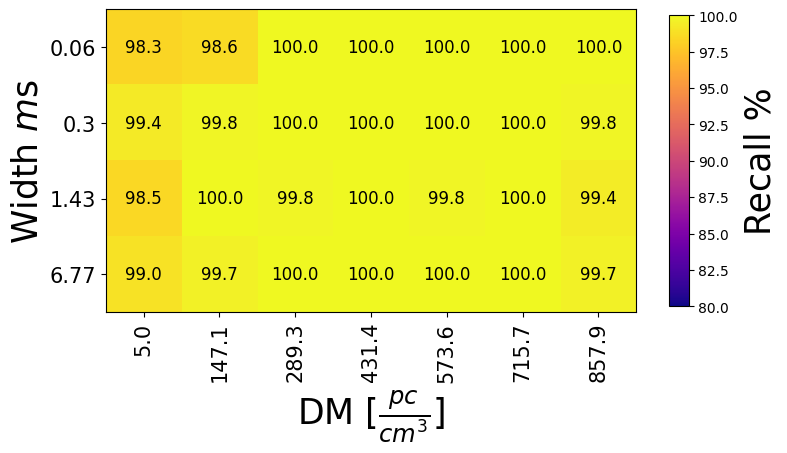

In [13]:
plt.figure(figsize=(8,10))
plt.imshow(recall_matrix.T, interpolation='nearest', vmin=80, vmax=100, cmap='plasma')

# Add text annotations to each cell
for i in range(recall_matrix.shape[0]):
    for j in range(recall_matrix.shape[1]):
        plt.text( i,j, f'{recall_matrix[i, j]:.1f}', ha='center', va='center', color='black',  fontsize = 12)

cb1 = plt.colorbar( label='Recall %',shrink=0.3, aspect=15,)
cb1.set_label('Recall %', fontsize=25)  # Set label font size

plt.ylabel('Width $m $s', fontsize = 25)
plt.xlabel('DM [$\\frac{pc}{cm^{3}}$]',  fontsize = 25)

xtick_positions = np.arange(0, recall_matrix.shape[1], 1)  # Custom x tick positions
ytick_positions = np.arange(0, recall_matrix.shape[0], 1)  # Custom y tick positions
xtick_labels    =  boxcar_ranges[:-1] * 1000# Custom x tick labels
print(boxcar_ranges)
for i in range(len(xtick_labels)):
    xtick_labels[i] = round(xtick_labels[i], 2)

ytick_labels = dm_ranges[:-1]  # Custom y tick labels
for i in range(len(ytick_labels)):
    ytick_labels[i] = round(ytick_labels[i], 1)


plt.xticks(ticks=ytick_positions, labels=ytick_labels, fontsize = 15, rotation='vertical')
plt.yticks(ticks=xtick_positions, labels=xtick_labels,  fontsize = 15, )
plt.tight_layout()

# plt.title('Retrieval Rate', fontsize = 30)
plt.savefig("8bit_recall_dm_width.pdf", format='pdf')

In [14]:
false_negative = np.zeros((dm_ranges.shape[0]-1,snr_ranges.shape[0]-1))
for i in range(1, dm_ranges.shape[0]):
    for j in range(1, snr_ranges.shape[0]):
        end_dm = dm_ranges[i]
        start_dm = dm_ranges[i-1]

        start_snr = snr_ranges[j-1]
        end_snr = snr_ranges[j]
    
        dm_index = set(np.where( np.logical_and(end_dm >np.array(results['dm']), start_dm<np.array(results['dm'])))[0].tolist())
        snr_index = set(np.where( np.logical_and(end_snr >results['snr'], start_snr< results['snr']))[0].tolist())
        label_index = set(np.where(1 == np.array(results['true']))[0].tolist())

        filtered = (np.array(list(dm_index & snr_index )),) 
        pred = np.where(np.array(results['pred'])[filtered] == 0)[0].shape[0] / np.array(results['pred'])[filtered].shape[0]
        false_negative[i-1,j-1] = pred * 100

[0 1 2 3 4 5 6] [10.   22.86 35.71 48.57 61.43 74.29 87.14] (7, 7)


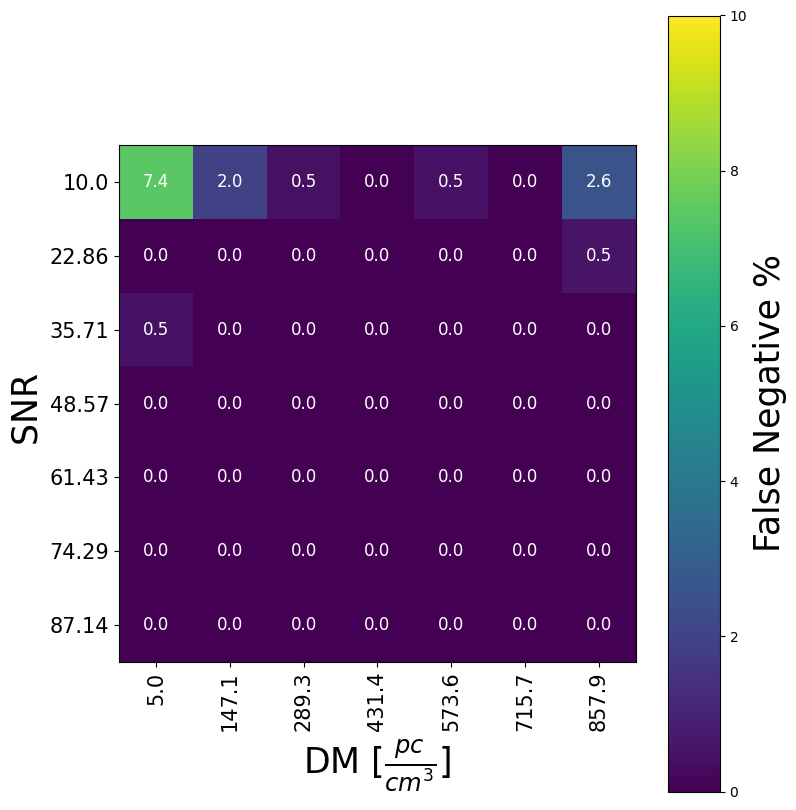

In [15]:
plt.figure(figsize=(8,10))
plt.imshow(false_negative.T, interpolation='nearest', vmin=0, vmax=10)

# Add text annotations to each cell
for i in range(false_negative.shape[0]):
    for j in range(false_negative.shape[1]):
        plt.text( i,j, f'{false_negative[i, j]:.1f}', ha='center', va='center', color='white',  fontsize = 12)

cb1 = plt.colorbar( label='False Negative %',shrink=0.8, aspect=15,)
cb1.set_label('False Negative %', fontsize=25)  # Set label font size

plt.ylabel('SNR ', fontsize = 25)
plt.xlabel('DM [$\\frac{pc}{cm^{3}}$]',  fontsize = 25)

xtick_positions = np.arange(0, false_negative.shape[1], 1)  # Custom x tick positions
ytick_positions = np.arange(0, false_negative.shape[0], 1)  # Custom y tick positions
xtick_labels    =  snr_ranges[:-1] # Custom x tick labels
for i in range(len(xtick_labels)):
    xtick_labels[i] = round(xtick_labels[i], 2)

ytick_labels = dm_ranges[:-1]  # Custom y tick labels
for i in range(len(ytick_labels)):
    ytick_labels[i] = round(ytick_labels[i], 2)

print(xtick_positions,xtick_labels , false_negative.shape)
plt.xticks(ticks=ytick_positions, labels=ytick_labels, fontsize = 15, rotation='vertical')
plt.yticks(ticks=xtick_positions, labels=xtick_labels,  fontsize = 15, )
plt.tight_layout()

# plt.title('Retrieval Rate', fontsize = 30)
plt.savefig("8bit_FN_dm_snr.pdf", format='pdf')

Text(0.5, 1.0, 'False Negative (% of true also predicted as false)')

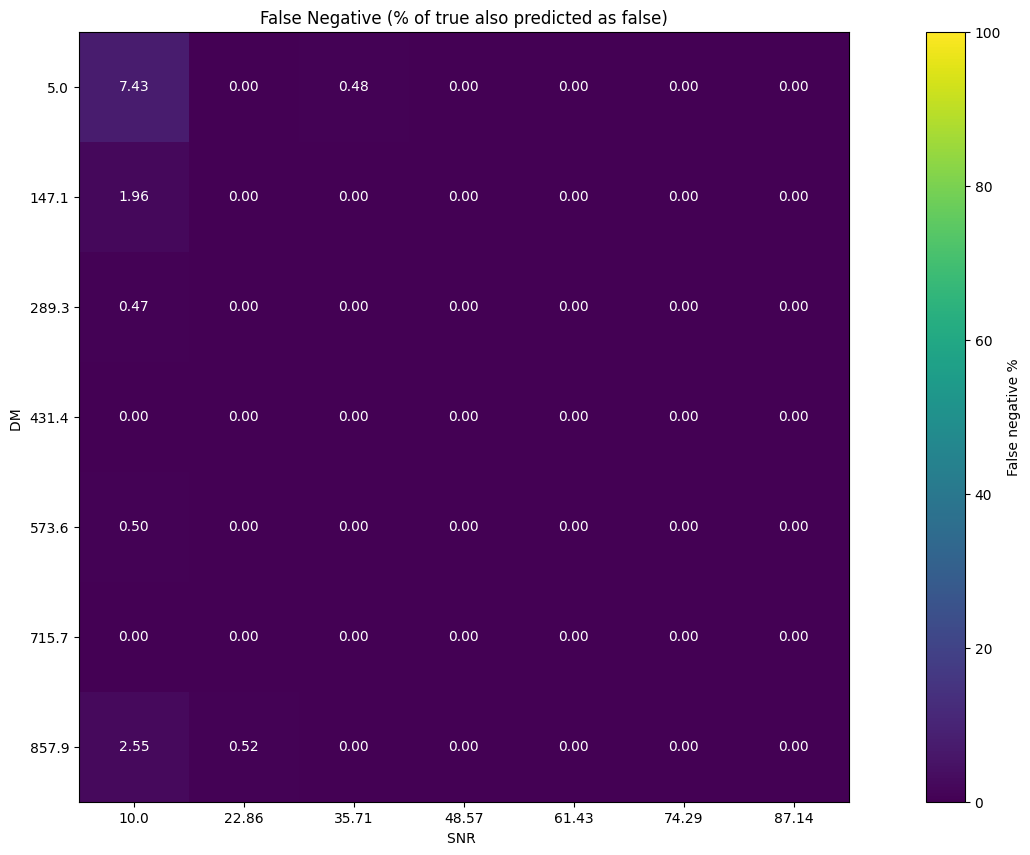

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(false_negative, interpolation='nearest', vmin=0, vmax=100)

# Add text annotations to each cell
for i in range(false_negative.shape[0]):
    for j in range(false_negative.shape[1]):
        plt.text(j, i, f'{false_negative[i, j]:.2f}', ha='center', va='center', color='white')

plt.colorbar( label='False negative %')
plt.xlabel('SNR ')
plt.ylabel('DM ')


xtick_positions = np.arange(0, false_negative.shape[1], 1)  # Custom x tick positions
ytick_positions = np.arange(0, false_negative.shape[0], 1)  # Custom y tick positions
xtick_labels =  snr_ranges[:-1]# Custom x tick labels
for i in range(len(xtick_labels)):
    xtick_labels[i] = round(xtick_labels[i], 2)

ytick_labels = dm_ranges[:-1]  # Custom y tick labels
for i in range(len(ytick_labels)):
    ytick_labels[i] = round(ytick_labels[i], 2)


plt.xticks(ticks=xtick_positions, labels=xtick_labels)
plt.yticks(ticks=ytick_positions, labels=ytick_labels)

plt.title('False Negative (% of true also predicted as false)')
# plt.savefig("FN_dm_snr.pdf", format='pdf')

In [17]:
from tqdm import tqdm
# eval
model.training
val_loss = 0.0
correct_valid = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in testloader:
        inputs, labels = images.to(device), labels
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_true.extend(labels[0].cpu().numpy().tolist())

AUC: 0.99535


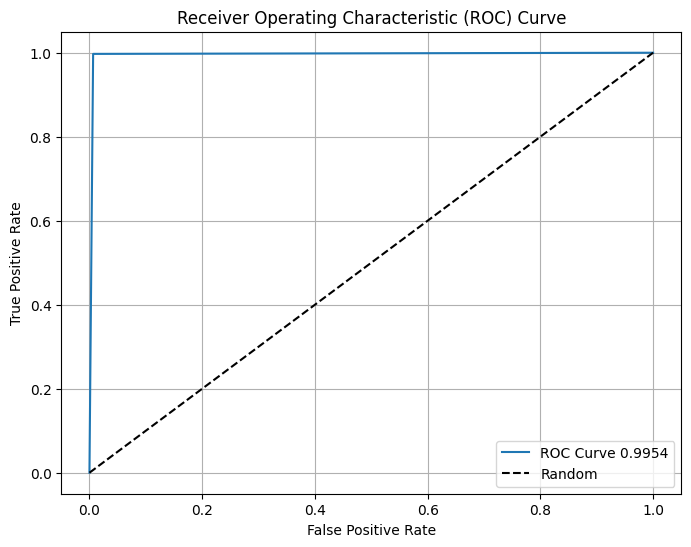

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Example data (replace with your actual data)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

print("AUC:", auc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve '+str(round(auc, 4)))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

[[9935   65]
 [  28 9972]]


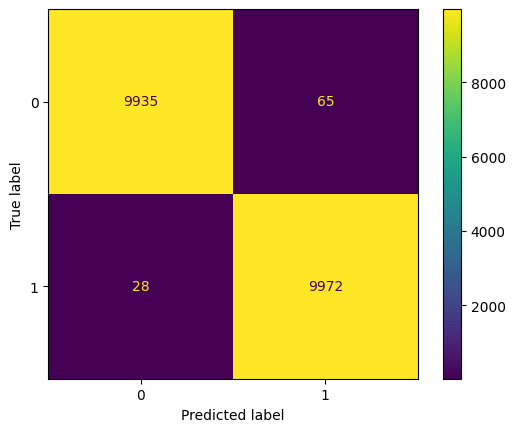

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [20]:
# Extract the number of False Positives (FP) and True Negatives (TN)
TN = cm[-1, -1]  # Bottom right element (True Negatives)
FP = cm[:-1, -1].sum()  # Sum of last column (excluding bottom right)

# Calculate FPR using the formula
FPR = FP / (FP + TN)

# Optional: Multiply by 100 for percentage
FPR_percentage = FPR * 100


TN = cm[-1, -1]  # Bottom right element (True Negatives)
TP = cm[1, 1]
FN = cm[1, 0]
FP = cm[:-1, -1].sum()  # Sum of last column (excluding bottom right)

TPR = TP / (TP + FN)
        
# Print the FPR
print("False Positive Rate (FPR):", FPR)
print('recall rate: ', TPR)
print("False Positive Rate (FPR in percentage):", FPR_percentage, "%")

False Positive Rate (FPR): 0.006476038656969214
recall rate:  0.9972
False Positive Rate (FPR in percentage): 0.6476038656969214 %


In [21]:
from sklearn.metrics import f1_score

# Calculate F1 score
f1 = f1_score(y_true, y_pred)

print("F1 score:", f1)

F1 score: 0.9953585866147627


In [22]:
min(results['freq'])

900.0026178010471

In [23]:
results['freq']

[1158.8507853403141,
 1430.7670157068062,
 1517.217277486911,
 2220.8821989528797,
 1530.7879581151833,
 1943.9397905759163,
 1299.0811518324608,
 907.541884816754,
 2016.8193717277486,
 903.520942408377,
 1112.107329842932,
 1363.9188481675392,
 1761.4895287958116,
 1145.280104712042,
 2055.520942408377,
 1364.4214659685863,
 1322.7041884816754,
 2043.458115183246,
 1209.6151832460732,
 2197.259162303665,
 1337.782722513089,
 2182.1806282722514,
 1157.84554973822,
 1281.4895287958116,
 1214.1387434554974,
 1543.3534031413612,
 1650.913612565445,
 1268.4214659685863,
 2148.505235602094,
 1445.84554973822,
 1307.6256544502617,
 973.3848167539267,
 1323.7094240837696,
 1596.630890052356,
 2008.7774869109949,
 2012.7984293193717,
 1253.3429319371728,
 1086.4738219895287,
 1147.7931937172775,
 1256.3586387434555,
 1831.3534031413612,
 1649.9083769633507,
 1382.0130890052355,
 1649.9083769633507,
 2160.5680628272253,
 1278.976439790576,
 1858.4947643979058,
 1209.1125654450261,
 1466.452879

In [24]:
accuracy_freq = np.zeros_like(freq_ranges)
fp_freq = np.zeros_like(freq_ranges)
tp_freq = np.zeros_like(freq_ranges)
for i in range(1, freq_ranges.shape[0]):
    end_f = freq_ranges[i]
    start_f = freq_ranges[i-1]
    
    f_index = np.where( np.logical_and(end_f > np.array(results['freq']), start_f<np.array(results['freq'])))[0].tolist()
    y_pred = np.array(results['pred'])[f_index]
    y_true = np.array(results['true'])[f_index]
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # Extract the number of False Positives (FP) and True Negatives (TN)
    TN = cm[-1, -1]  # Bottom right element (True Negatives)
    TP = cm[1, 1]
    FN = cm[1, 0]
    FP = cm[:-1, -1].sum()  # Sum of last column (excluding bottom right)
    # Calculate FPR using the formula
    if FP + TN != 0:
        FPR = FP / (FP + TN)
    else:
        FPR = 0

    if TP + FN != 0:
        TPR = TP / (TP + FN)
    else:
        TPR = 0
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_freq[i-1] = accuracy
    tp_freq[i-1] = TPR
    fp_freq[i-1] = FPR

Text(0.5, 0, 'Frequency [MHz]')

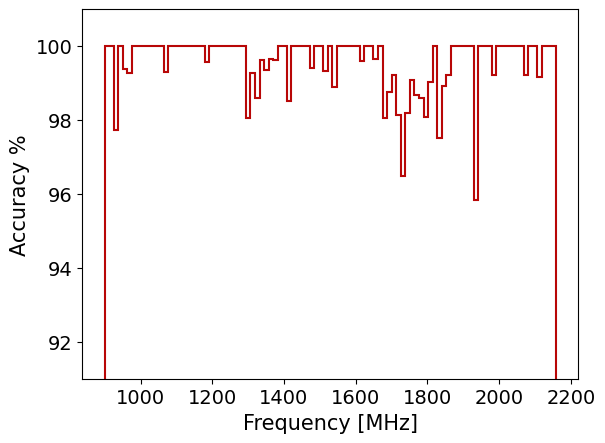

In [25]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.stairs( (accuracy_freq*100)[:-1], freq_ranges,linewidth = 1.5, color='#b80707')
plt.ylim(91, 101)
plt.ylabel('Accuracy %', fontsize = 15)
plt.xlabel('Frequency [MHz]',  fontsize = 15)

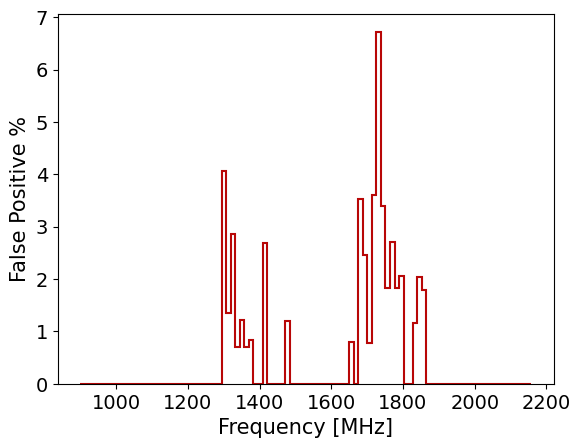

In [26]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.stairs( (fp_freq*100)[:-1], freq_ranges, linewidth = 1.5, color='#b80707')
plt.ylabel('False Positive %', fontsize = 15)
plt.xlabel('Frequency [MHz]',  fontsize = 15)
plt.savefig('false_positive.pdf', format='pdf')

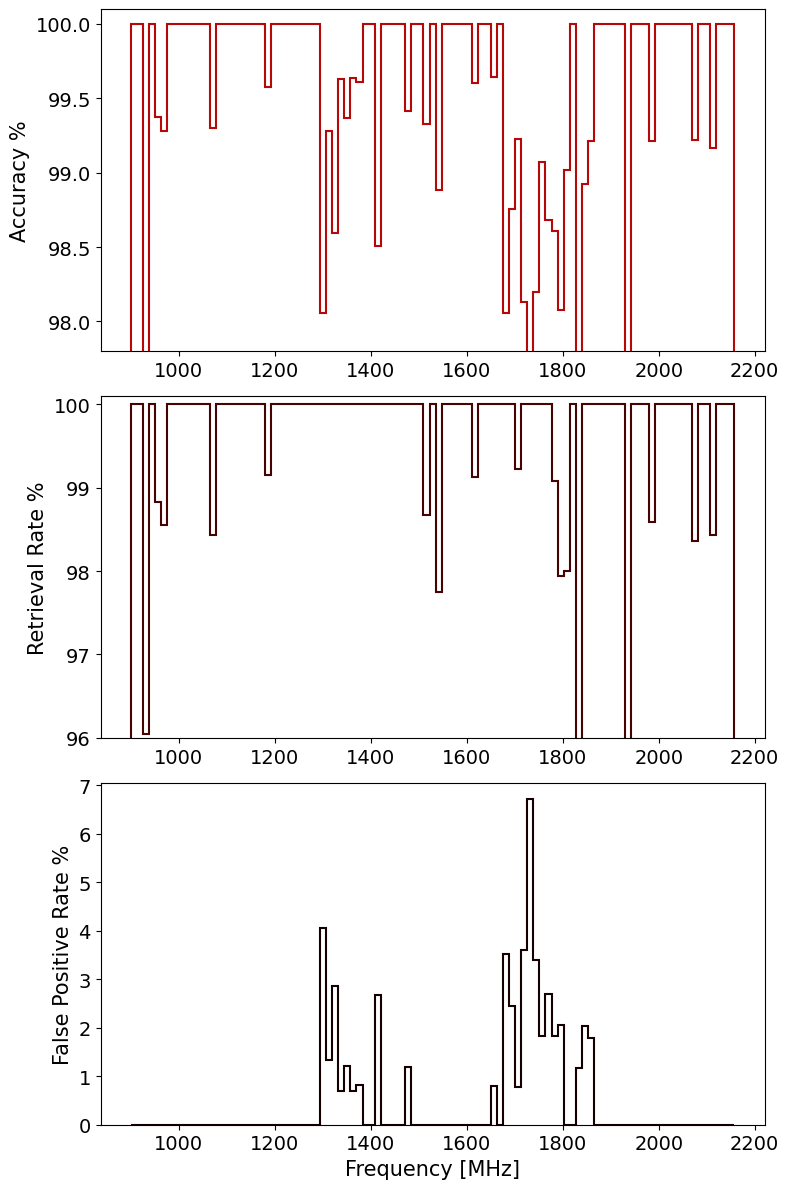

In [27]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 12))

# Create a GridSpec with 3 rows and 1 column
gs = gridspec.GridSpec(3, 1)

# First subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.stairs( (accuracy_freq*100)[:-1], freq_ranges,linewidth = 1.5, color='#b80707')
ax1.set_ylim(97.8, 100.1)
ax1.set_ylabel('Accuracy %', fontsize = 15)

# Second subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.stairs( (tp_freq*100)[:-1], freq_ranges, linewidth = 1.5, color='#470202')
ax2.set_ylabel('Retrieval Rate %', fontsize = 15)
ax2.set_ylim(96, 100.1)

# Third subplot
ax3 = fig.add_subplot(gs[2, 0])
ax3.stairs( (fp_freq*100)[:-1], freq_ranges, linewidth = 1.5, color='#140000')
ax3.set_ylabel('False Positive Rate %', fontsize = 15)
ax3.set_xlabel('Frequency [MHz]', fontsize = 15)

# Adjust layout
plt.tight_layout()
plt.savefig('freq_fp_recall_accuracy.pdf', format='pdf')
# Show the plot
plt.show()

In [28]:
import pickle
data ={"acc":accuracy_freq, 'fp':fp_freq, "tp":tp_freq, 'freq':freq_ranges}
# Open a file for writing binary data
with open('8bit_.pkl', 'wb') as file:
    # Use pickle.dump to write the data to the file
    pickle.dump(data, file)

In [29]:
# # thresholds = np.power(10, np.linspace(-0.3010299956639812, 0, 100))
# thresholds = [0.5]
# thresholds.extend(np.linspace(0.6, 0.7, 3))
# thresholds.extend(np.linspace(0.7, 0.8, 10)[1:])
# thresholds.extend(np.linspace(0.8, 0.9, 20)[1:])
# thresholds.extend(np.linspace(0.9, 1, 30)[1:])

In [30]:
# thresholds = np.array(thresholds)

In [31]:
# from tqdm import tqdm
# from torch.nn import Softmax
# # eval
# model.training
# val_loss = 0.0
# correct_valid = 0
# total = 0
# results = {'pred': [], 'true':[], 'freq':[], 'snr':[], 'dm':[]}
# model.eval()
# fp_rates = []
# accuracy_rates = []
# recall_rates = []
# for i in tqdm(range(thresholds.shape[0])):
#     y_true = []
#     y_pred = []
#     threshold = thresholds[i]
#     with torch.no_grad():
#         for images, labels in testloader:
#             inputs, labels = images.to(device), labels
#             outputs = nn.Softmax(dim = 1)(model(inputs))
#             selection = outputs[:, 1] > threshold
#             predicted = selection.int()
#             y_pred.extend(predicted.cpu().numpy().tolist())
#             y_true.extend(labels[0].cpu().numpy().tolist())

#     cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
#     TN = cm[-1, -1]  # Bottom right element (True Negatives)
#     TP = cm[1, 1]
#     FN = cm[1, 0]
#     FP = cm[:-1, -1].sum()  # Sum of last column (excluding bottom right)
#     if FP + TN != 0:
#         FPR = FP / (FP + TN)
#     else:
#         FPR = 0

#     if TP + FN != 0:
#         TPR = TP / (TP + FN)
#     else:
#         TPR = 0
#     accuracy = accuracy_score(y_true, y_pred)
#     fp_rates.append(FPR)
#     recall_rates.append(TPR)
#     accuracy_rates.append(accuracy)


In [32]:
# # Create a figure and a single subplot
# fig, ax1 = plt.subplots(figsize=(8,5))

# # Plot the first line (y1) on the primary y-axis
# ax1.plot(thresholds, np.array(recall_rates)*100, '#b80707', label='Retrieval')
# ax1.set_xlabel('Threshold', fontsize = 15)
# ax1.set_ylabel('Retrieval %', color='#b80707', fontsize = 15)
# ax1.tick_params(axis='y', labelcolor='#b80707')
# ax1.set_ylim(99,99.7)
# ax1.axvline(x=0.992, color='blue', linestyle='--', label='Threshold = 0.992')  # Vertical line at x=5

# # Create a secondary y-axis
# ax2 = ax1.twinx()
# # Plot the second line (y2) on the secondary y-axis
# ax2.plot(thresholds, np.array(fp_rates)*100, '#140000', linestyle = '-', label='False Positive')
# ax2.set_ylabel('False Positive Rate %', color='#140000', fontsize = 15)
# ax2.tick_params(axis='y', labelcolor='#140000')
# ax2.set_ylim(0,0.2)

# # Add legends
# ax1.legend(loc='lower left', fontsize = 12)
# ax2.legend(loc='lower right', fontsize = 12)
# ax2.set_xlim(0.9, 1)
# ax1.set_xlim(0.9,1)
# # Show the plot
# plt.tight_layout()
# plt.savefig('profile.pdf', format='pdf')

# plt.show()

In [33]:
# fig, ax1 = plt.subplots()

# # Plot the first line (y1) on the primary y-axis
# ax1.plot(thresholds, np.array(recall_rates)*100, '#b80707', label='Retrieval')
# ax1.set_xlabel('Threshold', fontsize = 15)
# ax1.set_ylabel('Retrieval %', color='#b80707', fontsize = 15)
# ax1.tick_params(axis='y', labelcolor='#b80707')
# ax1.set_ylim(99,99.7)
# ax1.axvline(x=0.992, color='blue', linestyle='--', label='Threshold = 0.992')  # Vertical line at x=5

# # Create a secondary y-axis
# ax2 = ax1.twinx()
# # Plot the second line (y2) on the secondary y-axis
# ax2.plot(thresholds, np.array(fp_rates)*100, '#140000', linestyle = '-', label='False Positive')
# ax2.set_ylabel('False Positive Rate %', color='#140000', fontsize = 15)
# ax2.tick_params(axis='y', labelcolor='#140000')
# # ax2.set_ylim(0,0.2)

# # Add legends
# ax1.legend(loc='lower left', fontsize = 12)
# ax2.legend(loc='lower right', fontsize = 12)
# # ax2.set_xlim(0.9, 1)
# # ax1.set_xlim(0.9,1)
# # Show the plot
# plt.savefig('profile.pdf', format='pdf')
# plt.show()